
This notebook performs **several NLP tasks** on the insurance customer reviews dataset:
1. Exploratory Data Analysis (EDA)
2. Sentiment Analysis (predicting 'sentiment')
3. Rating Prediction (predicting 'rating')
4. Text Classification (predicting 'insurance_type')
5. Topic Modeling (identifying topics in 'review_text')

# Import

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer # Optional: for stemming

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error
from sklearn.decomposition import LatentDirichletAllocation


In [2]:

# Download necessary NLTK data (if not already downloaded)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

# Load the dataset
file_path = '/kaggle/input/insurance-customer-reviews-crm-action-plans/insurance_customer_reviews_gemini_enhanced.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please ensure the file path is correct.")

Dataset loaded successfully.
Shape: (400, 8)


# Exploratory Data Analysis (EDA)

In [3]:


# Display basic information
print("\nDataset Info:")
df.info()

# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics (Numerical):")
print(df.describe())

# Display value counts for categorical columns
print("\nValue Counts (Sentiment):")
print(df['Sentiment'].value_counts())

print("\nValue Counts (Rating):")
print(df['Rating'].value_counts().sort_index())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ReviewID       400 non-null    int64 
 1   CustomerID     400 non-null    int64 
 2   ReviewDate     400 non-null    object
 3   Rating         400 non-null    int64 
 4   ReviewText     400 non-null    object
 5   Sentiment      400 non-null    object
 6   GeneratedTask  400 non-null    object
 7   AIGenerated    400 non-null    bool  
dtypes: bool(1), int64(3), object(4)
memory usage: 22.4+ KB

Descriptive Statistics (Numerical):
         ReviewID  CustomerID      Rating
count  400.000000  400.000000  400.000000
mean   200.500000  193.887500    2.892500
std    115.614301  107.367777    1.282598
min      1.000000    2.000000    1.000000
25%    100.750000  100.000000    2.000000
50%    200.500000  201.000000    3.000000
75%    300.250000  289.000000    4.000000
max    400.000000 

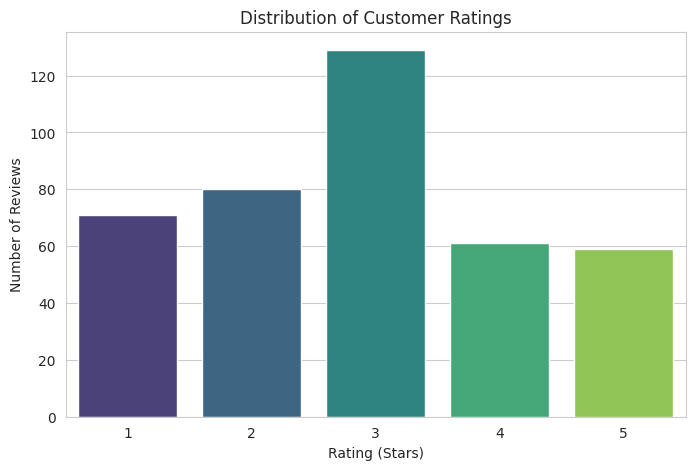

In [4]:
# Distribution of Ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=df, palette='viridis', order=sorted(df['Rating'].unique())) # --> Changed: rating -> Rating
plt.title('Distribution of Customer Ratings')
plt.xlabel('Rating (Stars)') # --> Changed: Rating -> Rating (Stars)
plt.ylabel('Number of Reviews')
plt.show()


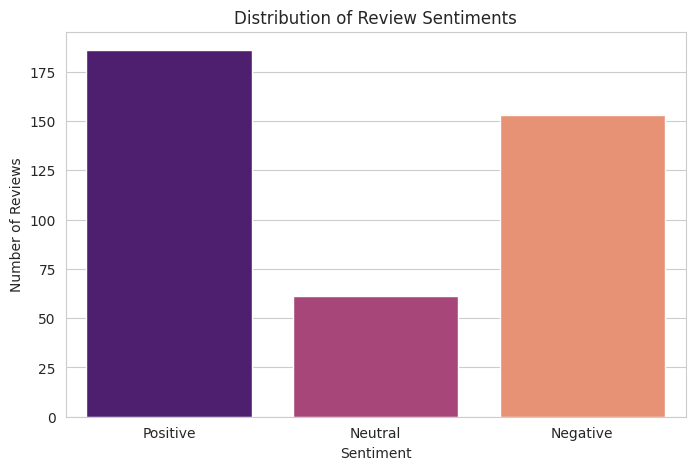

In [5]:
# Distribution of Sentiments
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment', data=df, palette='magma', order=['Positive', 'Neutral', 'Negative']) # --> Changed: sentiment -> Sentiment
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment') # --> Changed: Sentiment -> Sentiment
plt.ylabel('Number of Reviews')
plt.show()


 # Text Preprocessing

In [6]:
standard_stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer() # Optional stemmer


custom_stopwords = ['insurance', 'policy', 'ive', 'company', 'name', 'im', 'experience', 'customer', 'customers']

stop_words=standard_stopwords.union(set(custom_stopwords))

def preprocess_text(text):
    """Cleans and preprocesses text data."""
    if not isinstance(text, str):
        return "" # Return empty string for non-string inputs
    text = text.lower() # Lowercase
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = text.strip() # Remove leading/trailing whitespace
    tokens = word_tokenize(text) # Tokenize
    # Remove stopwords and optionally stem
    # processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words] # With stemming
    processed_tokens = [word for word in tokens if word not in stop_words] # Without stemming
    return ' '.join(processed_tokens)

# Apply preprocessing to the ReviewText column
print("\nPreprocessing text...")
df['processed_text'] = df['ReviewText'].apply(preprocess_text) # --> Changed: review_text -> ReviewText
print("Text preprocessing complete.")
print("\nSample processed text:")
print(df[['ReviewText', 'processed_text']].head(10)) # --> Changed: review_text -> ReviewText



Preprocessing text...
Text preprocessing complete.

Sample processed text:
                                          ReviewText  \
0  My experience with Acme Insurance was... adequ...   
1  I've been with Stellar Insurance for five year...   
2  I am utterly disappointed with my experience f...   
3  I've been with [Insurance Company Name] for ov...   
4  I recently needed to make a small adjustment t...   
5  My experience with InsureEasy's website was......   
6  I recently had a minor fender bender, and I wa...   
7  I've been with SecureSure Insurance for severa...   
8  I recently had to navigate some rather complex...   
9  I'm extremely frustrated with my recent experi...   

                                      processed_text  
0  acme adequate contacted get quote renters agen...  
1  stellar five years always happy service year t...  
2  utterly disappointed filing water damage claim...  
3  five years generally satisfied however recentl...  
4  recently needed make small ad

# Feature Engineering (TF-IDF)

In [7]:
# Convert the processed text into numerical features using TF-IDF.

# %%
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limit features to top 5000

print("\nCreating TF-IDF features...")
# Create TF-IDF matrix using the 'processed_text' column
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])
print("TF-IDF features created.")
print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")



Creating TF-IDF features...
TF-IDF features created.
Shape of TF-IDF matrix: (400, 2884)


# Sentiment Analysis (Predicting Sentiment)


--- Task 1: Sentiment Analysis ---
Training Sentiment Analysis model (Logistic Regression)...
Evaluating Sentiment Analysis model...

Sentiment Analysis Accuracy: 0.9500
Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.97      0.99        38
     Neutral       0.86      0.80      0.83        15
    Positive       0.94      0.98      0.96        47

    accuracy                           0.95       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.95      0.95      0.95       100



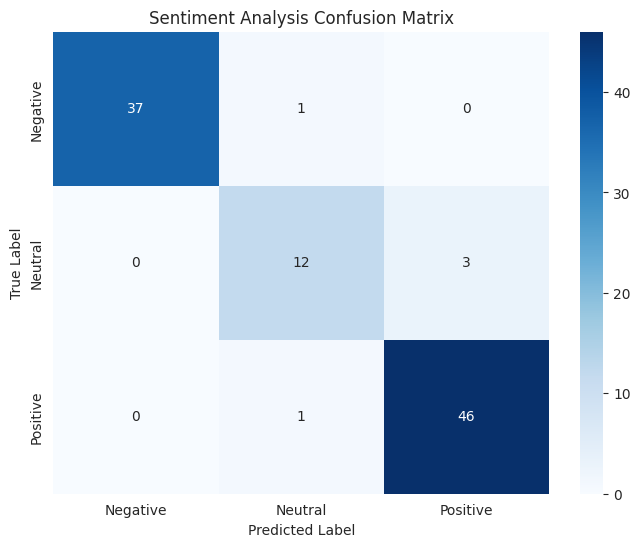

In [8]:

# %%
print("\n--- Task 1: Sentiment Analysis ---")

# Define features (X) and target (y)
X_sentiment = X_tfidf
y_sentiment = df['Sentiment'] # --> Changed: sentiment -> Sentiment

# Split data
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    X_sentiment, y_sentiment, test_size=0.25, random_state=42, stratify=y_sentiment
)

# Train a Logistic Regression model
print("Training Sentiment Analysis model (Logistic Regression)...")
model_sentiment = LogisticRegression(max_iter=1000, random_state=42)
model_sentiment.fit(X_train_sent, y_train_sent)

# Predict and evaluate
print("Evaluating Sentiment Analysis model...")
y_pred_sent = model_sentiment.predict(X_test_sent)
accuracy_sent = accuracy_score(y_test_sent, y_pred_sent)
report_sent = classification_report(y_test_sent, y_pred_sent)

print(f"\nSentiment Analysis Accuracy: {accuracy_sent:.4f}")
print("Classification Report:")
print(report_sent)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_sent = confusion_matrix(y_test_sent, y_pred_sent, labels=model_sentiment.classes_)
sns.heatmap(cm_sent, annot=True, fmt='d', cmap='Blues', xticklabels=model_sentiment.classes_, yticklabels=model_sentiment.classes_)
plt.title('Sentiment Analysis Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#  Rating Prediction (Predicting Rating)


--- Task 2: Rating Prediction ---
Training Rating Prediction model (Linear SVC)...
Evaluating Rating Prediction model...

Rating Prediction Accuracy: 0.6100
Rating Prediction Mean Absolute Error (MAE): 0.4000
Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.33      0.36        18
           2       0.48      0.55      0.51        20
           3       0.97      1.00      0.98        32
           4       0.45      0.67      0.54        15
           5       0.29      0.13      0.18        15

    accuracy                           0.61       100
   macro avg       0.52      0.54      0.52       100
weighted avg       0.59      0.61      0.59       100



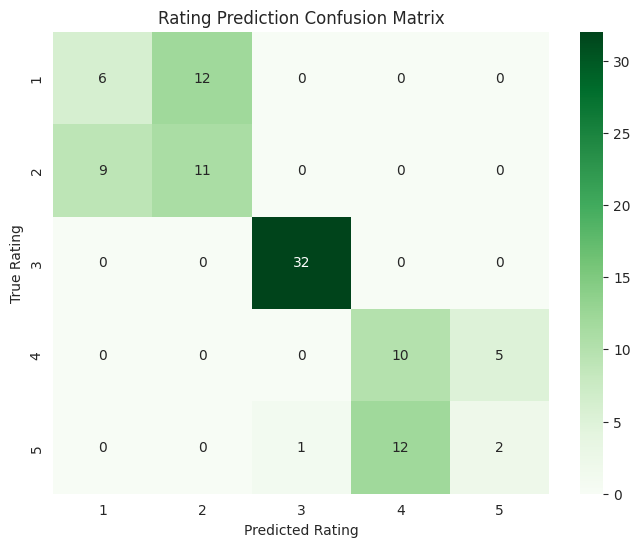

In [9]:

print("\n--- Task 2: Rating Prediction ---")

# Define features (X) and target (y)
# Using the same TF-IDF features
X_rating = X_tfidf
y_rating = df['Rating'] # --> Changed: rating -> Rating

# Split data - stratify might be important due to rating distribution
X_train_rate, X_test_rate, y_train_rate, y_test_rate = train_test_split(
    X_rating, y_rating, test_size=0.25, random_state=42, stratify=y_rating # --> Changed: y_rating
)

# Train a Linear SVC model (often good for text classification)
print("Training Rating Prediction model (Linear SVC)...")
# dual=True can be helpful for smaller samples or when n_features > n_samples
# If you encounter convergence issues, you might try dual=False or increase max_iter
model_rating = LinearSVC(random_state=42, C=0.5, max_iter=2000, dual=True)
model_rating.fit(X_train_rate, y_train_rate)

# Predict and evaluate
print("Evaluating Rating Prediction model...")
y_pred_rate = model_rating.predict(X_test_rate)
accuracy_rate = accuracy_score(y_test_rate, y_pred_rate)
report_rate = classification_report(y_test_rate, y_pred_rate)
mae_rate = mean_absolute_error(y_test_rate, y_pred_rate) # Also show MAE

print(f"\nRating Prediction Accuracy: {accuracy_rate:.4f}")
print(f"Rating Prediction Mean Absolute Error (MAE): {mae_rate:.4f}") # Lower is better
print("Classification Report:")
print(report_rate)

# Confusion Matrix
plt.figure(figsize=(8, 6))
# Ensure labels are sorted for consistent matrix display
rating_labels = sorted(y_rating.unique())
cm_rate = confusion_matrix(y_test_rate, y_pred_rate, labels=rating_labels)
sns.heatmap(cm_rate, annot=True, fmt='d', cmap='Greens', xticklabels=rating_labels, yticklabels=rating_labels)
plt.title('Rating Prediction Confusion Matrix')
plt.xlabel('Predicted Rating') # --> Changed: Rating -> Rating
plt.ylabel('True Rating') # --> Changed: Rating -> Rating
plt.show()



#  Topic Modeling (Identifying Topics)

In [10]:

print("\n--- Task 3: Topic Modeling (LDA) ---") # Task number updated

# Create CountVectorizer features for LDA
print("Creating CountVectorizer features for LDA...")
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, # Ignore terms that appear in >95% or <2 documents
                                 max_features=1000,     # Limit features
                                 stop_words='english')
X_count = count_vectorizer.fit_transform(df['processed_text']) # Using 'processed_text'
print("CountVectorizer features created.")

# Define the number of topics
n_topics = 10# Adjust based on dataset size and desired granularity

# Train the LDA model
print(f"Training LDA model with {n_topics} topics...")
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, n_jobs=-1) # Use all available CPUs
lda.fit(X_count)
print("LDA model training complete.")

# Function to display topics
def display_topics(model, feature_names, n_top_words):
    print("\n--- Identified Topics ---")
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx+1}: "
        message += " | ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

# Display the top words for each topic
n_top_words = 5
feature_names = count_vectorizer.get_feature_names_out()
display_topics(lda, feature_names, n_top_words)



--- Task 3: Topic Modeling (LDA) ---
Creating CountVectorizer features for LDA...
CountVectorizer features created.
Training LDA model with 10 topics...
LDA model training complete.

--- Identified Topics ---
Topic #1: process | entire | claim | recommend | incredibly
Topic #2: felt | coverage | service | renewal | didnt
Topic #3: damage | claim | felt | process | left
Topic #4: claim | different | information | representative | incredibly
Topic #5: online | process | easy | confirmation | payment
Topic #6: app | online | website | information | easily
Topic #7: needed | felt | interaction | automated | process
Topic #8: agent | incredibly | recent | trying | service
Topic #9: time | service | unacceptable | representative | years
Topic #10: representative | minutes | interaction | answered | polite



#  Assign dominant topic to each review

In [11]:

topic_results = lda.transform(X_count)
df['dominant_topic'] = topic_results.argmax(axis=1)
print("\nDominant topic assigned to each review (sample):")
print(df[['ReviewText', 'dominant_topic']].head()) # --> Changed: review_text -> ReviewText




Dominant topic assigned to each review (sample):
                                          ReviewText  dominant_topic
0  My experience with Acme Insurance was... adequ...               6
1  I've been with Stellar Insurance for five year...               1
2  I am utterly disappointed with my experience f...               2
3  I've been with [Insurance Company Name] for ov...               3
4  I recently needed to make a small adjustment t...               4
